In [140]:
import torch
from torchvision import transforms
import glob
import re
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Preprocess import DataReader
from torch.utils.data import DataLoader
import pickle


hist = []
acc_hist = []

## Preprocess

In [3]:
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
lower_char = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
              'v', 'w', 'x', 'y', 'z']
upper_char = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
              'V', 'W', 'X', 'Y', 'Z']

total = nums + lower_char + upper_char
classes = {}
for i in range(len(total)):
    classes[str(total[i])] = i

In [193]:
BATCH_SIZE = 32
transform = transforms.Compose([transforms.ToTensor(),])
train = DataReader('Charset/train/',transform,class_dict = classes)
test = DataReader('Charset/test/', transform, class_dict = classes)
trainset = DataLoader(train,batch_size=BATCH_SIZE)
testset = DataLoader(test,batch_size=BATCH_SIZE)

In [194]:
for batch in trainset:
    features, labels = batch
    break
_iter = iter(range(BATCH_SIZE)) 

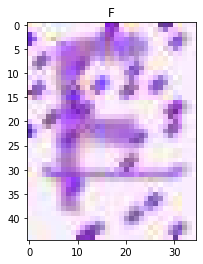

In [195]:
index = next(_iter)
plt.title(total[labels[index]])
plt.imshow(features[index].permute(1,2,0))
plt.show()

## Train

In [175]:
def evaluate():
    total = 0.
    correct = 0.
    with torch.no_grad():
        for batch in testset:
            features, labels = batch
            out = net(features.cuda())
            for i,x in enumerate(out):
                if torch.argmax(x) == labels[i]:
                    correct += 1
            total += len(labels)
        acc = correct/total
        acc_hist.append(acc)
    return acc
#     print(f"Total -> {total}")
#     print(f"Correct -> {correct}")
#     print("Accuracy -> [%.5f]"%acc)
#     plt.title("Accuracy -> [%.5f]"%acc)
#     plt.plot(acc_hist)
#     plt.show()

In [181]:
class Classification_Net(torch.nn.Module):
    def __init__(self):
        super(Classification_Net, self).__init__()
        
        self.conv2d = torch.nn.Sequential(
            torch.nn.Conv2d(3,32,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,1),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128,256,2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256,512,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(1,1),
            torch.nn.Conv2d(512,784,1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(1,1),
            torch.nn.BatchNorm2d(784),
            torch.nn.Conv2d(784,512,2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,1),
            torch.nn.Conv2d(512,384,2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(768,2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048,3000),
            torch.nn.ReLU(),
            torch.nn.Linear(3000,2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 960),
            torch.nn.BatchNorm1d(960),
            torch.nn.Linear(960, 360),
            torch.nn.ReLU(),
            torch.nn.Linear(360,120),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(120, 62),
            torch.nn.ReLU(),
        )
        
    def forward(self, inputs):
        o = self.conv2d(inputs).reshape(len(inputs),384,-1)
        o = self.dense(o)
        return o
net = Classification_Net().cuda()


In [203]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer,[10,25],0.9,-1)
criterion = torch.nn.CrossEntropyLoss()
MODEL_PATH = "char_classification.pth"
# net.load_state_dict(torch.load(MODEL_PATH))

EPOCH: 1/10  1875/1875 [AVG Loss -> 1.48762]	Evaluation Accuracy -> 0.62522
EPOCH: 2/10  1875/1875 [AVG Loss -> 1.48447]	Evaluation Accuracy -> 0.62567
EPOCH: 3/10  1875/1875 [AVG Loss -> 1.48338]	Evaluation Accuracy -> 0.62411
EPOCH: 4/10  1875/1875 [AVG Loss -> 1.48394]	Evaluation Accuracy -> 0.62300
EPOCH: 5/10  1875/1875 [AVG Loss -> 1.48594]	Evaluation Accuracy -> 0.62422
EPOCH: 6/10  1875/1875 [AVG Loss -> 1.48224]	Evaluation Accuracy -> 0.62633
EPOCH: 7/10  1875/1875 [AVG Loss -> 1.48367]	Evaluation Accuracy -> 0.62367
EPOCH: 8/10  1875/1875 [AVG Loss -> 1.48544]	Evaluation Accuracy -> 0.61856
EPOCH: 9/10  1875/1875 [AVG Loss -> 1.48453]	Evaluation Accuracy -> 0.62422
EPOCH: 10/10  1875/1875 [AVG Loss -> 1.48267]	Evaluation Accuracy -> 0.62444


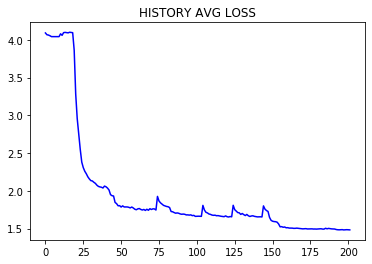

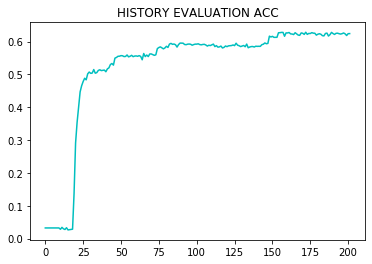

In [204]:
EPOCHS = 10
def fit(hist):
    for e in range(EPOCHS):
        running_loss = 0.
        for i, batch in enumerate(trainset):
            features, labels = batch
            out = net(features.cuda())
            loss = criterion(out, labels.cuda())
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            print(f"\rEPOCH: {e+1}/{EPOCHS}  {i+1}/{len(trainset)} [AVG Loss -> %.5f]"%(running_loss/(i+1)),end="")
            sys.stdout.flush()
        schedular.step()
        hist.append(running_loss/len(trainset))
        eval_acc = evaluate()
        print("\tEvaluation Accuracy -> %.5f"%eval_acc)
fit(hist)
plt.title('HISTORY AVG LOSS')
plt.plot(hist,'b')
plt.show()
plt.title('HISTORY EVALUATION ACC')
plt.plot(acc_hist,'c')
plt.show()

In [206]:
# torch.save(net.state_dict(),MODEL_PATH)

In [ ]:
def save_hist_plot():
    dic = {'hist_loss':hist, 'hist_acc':acc_hist}
    with open("hist_plot.pkl",'wb') as F:
        pickle.dump(dic,F,protocol=pickle.HIGHEST_PROTOCOL)